In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./Project_2.ipynb
./.ipynb_checkpoints/Project_2-checkpoint.ipynb
./data/houseData.csv
./data/.ipynb_checkpoints/houseData-checkpoint.csv


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

We need to create a model which can accurately predict the housing price given a set list of parameters throughout Oakland, California and the surrounding Bay Area. Given values such as zip code, square footage, bedrooms, and bathrooms, we will train a learning model using these parameters attached to their listing price, likely using supervised learning, in order to label home prices with new parameters but without the price.

In [2]:
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import re

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

Got the data through using the Apify website's Zillow Search Scraper robot, placing all the information about each house listing in the houseData.csv file, though I did receive some unhelpful columns that need transforming, such as the imageSrc having useless links and two other columns needeing to be filtered for just zip code and price, respectively.

In [3]:
df = pd.read_csv('data/houseData.csv')
df = df.rename(columns={'detailUrl':'zip', 'hdpData.homeInfo.bathrooms':'baths', 'hdpData.homeInfo.bedrooms':'beds', 'hdpData.homeInfo.livingArea':'area'})


Needed to update the data, removing the image link column, filtering for just the zip code on another column, and removing anything that isnt a number on the other columns.

In [4]:
# drop rows without bathroom values (all these rows also dont have bed or area values
df_new = df.dropna(subset=['area']).reset_index(drop=True)
df_new = df_new.dropna(subset=['beds']).reset_index(drop=True)
# delete the image link column
df_new = df_new.drop(columns = 'imgSrc')

import re
# set the price values to floats without dollars signs or commas
df_new['price'] = df_new['price'].str.replace(r'\D', '', regex=True).astype(float)

# filter for just zip code


deletable = []
match = r"-\b\d{5}\b/"
i=0
def identif(url):
    try:
        x = re.search(match, url)
        df_new.iloc[i,0] = x.group()[1:-1]
    except Exception:
        deletable.append(i)
        pass
        
for n in df_new.zip:
    identif(n)
    i+=1
df_clean = df_new.drop(deletable)

df_clean = df_clean.dropna()
df_population = df_clean.copy()

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

Used Matplotlib and pandas together, graphing the data in various ways in order to identify some consistent trends.

Here's what I tried to find trends with (Will list them with the code boxes as I go:

In [5]:
print(df_clean.head(1))

     zip     price  baths  beds    area
1  95112  998000.0    2.0   4.0  1040.0


Scatter plots - helped me view outliers of each comparison of data

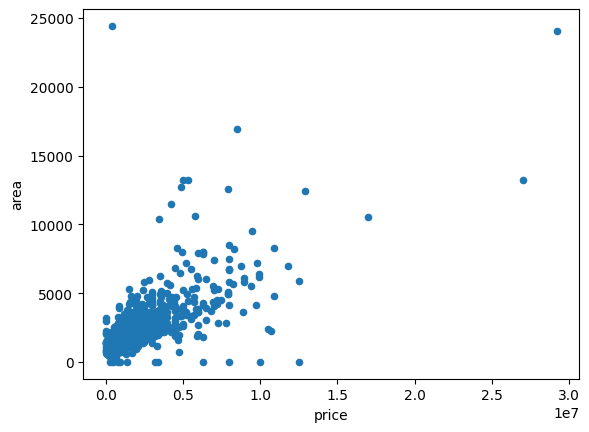

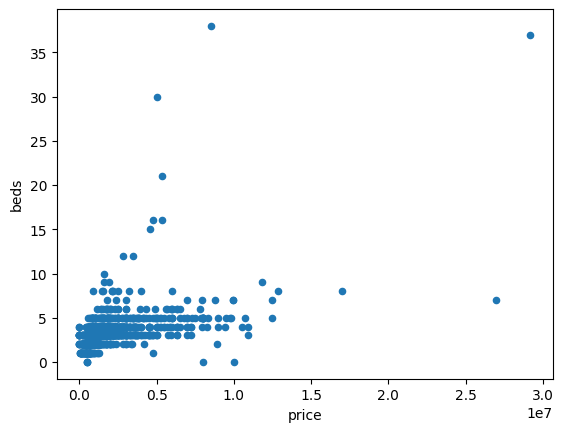

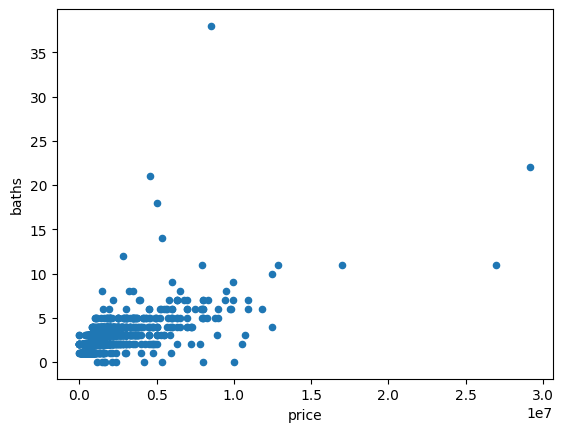

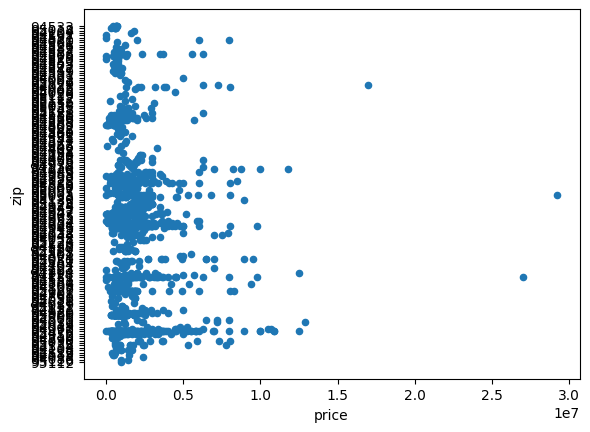

In [6]:
df_clean.plot(kind= 'scatter', x='price', y='area')
df_clean.plot(kind= 'scatter', x='price', y='beds')
df_clean.plot(kind= 'scatter', x='price', y='baths')
df_clean.plot(kind= 'scatter', x='price', y='zip')


plt.show()

Then boxplots, to see the median income of certain comparisons, noting that 7 beds had a significantly higher median than expected (abt 850k)
I also tried combining bed and bath boxplots because I felt that was an important block to consider, showing me that bedrooms generally have a higher effect on house price than bathrooms.

<Figure size 1000x600 with 0 Axes>

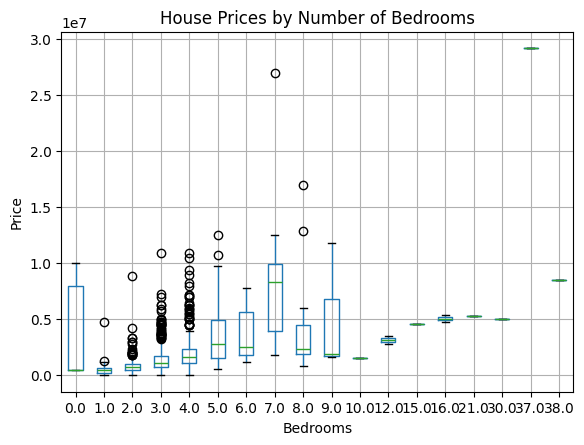

<Figure size 1200x600 with 0 Axes>

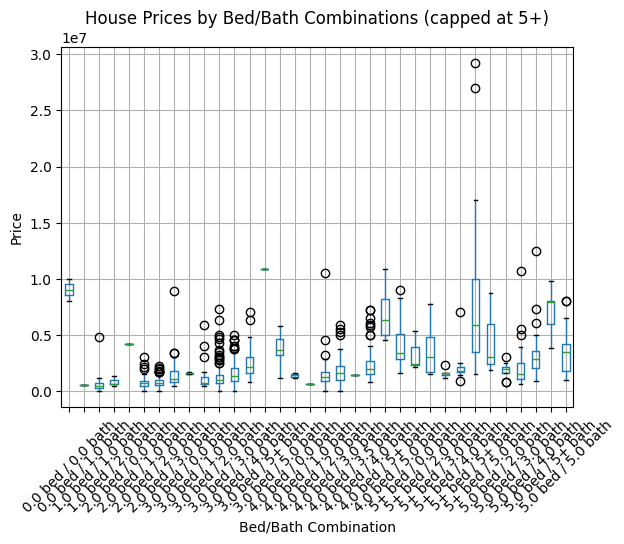

<Figure size 1200x600 with 0 Axes>

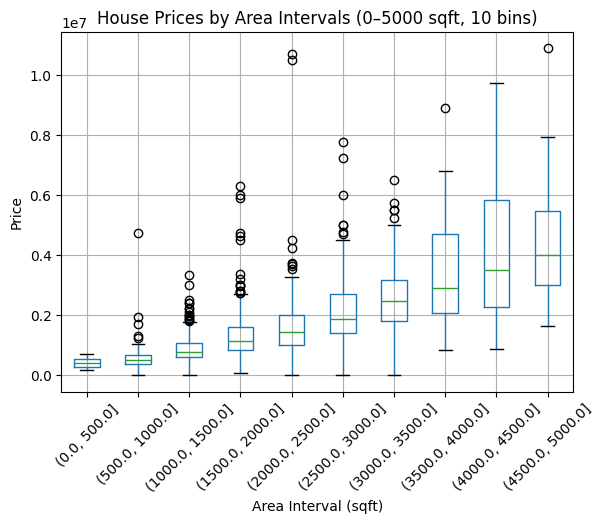

In [7]:
plt.figure(figsize=(10,6))
df_clean.boxplot(column='price', by='beds')
plt.title('House Prices by Number of Bedrooms')
plt.suptitle('')  
plt.xlabel('Bedrooms')
plt.ylabel('Price')

df_clean['beds_capped'] = df_clean['beds'].apply(lambda x: str(x) if x <= 5 else '5+')
df_clean['baths_capped'] = df_clean['baths'].apply(lambda x: str(x) if x <= 5 else '5+')

df_clean['bed_bath'] = df_clean['beds_capped'] + ' bed / ' + df_clean['baths_capped'] + ' bath'


plt.figure(figsize=(12,6))
df_clean.boxplot(column='price', by='bed_bath', rot=45)
plt.title('House Prices by Bed/Bath Combinations (capped at 5+)')
plt.suptitle('')
plt.xlabel('Bed/Bath Combination')
plt.ylabel('Price')

import numpy as np

bins = np.linspace(0, 5000, 11)  
df_clean['area_bin'] = pd.cut(df_new['area'], bins=bins)


plt.figure(figsize=(12,6))
df_clean.boxplot(column='price', by='area_bin', rot=45)
plt.title('House Prices by Area Intervals (0–5000 sqft, 10 bins)')
plt.suptitle('') 
plt.xlabel('Area Interval (sqft)')
plt.ylabel('Price')
plt.show()


# 4. Prepare the Data


Apply any data transformations and explain what and why


I need to adjust outliers of this set, so I will utilize these boxplots to find outliers in both the area interval and bed/bath sets.
In this case, I chose to give outliers greater than 3 times Tukey's formula for outliers, which MatPlotLib uses, and set those values to be closer to the median of the set.


In [15]:

Q1 = df_population["area"].quantile(0.25)
Q3 = df_population["area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 5 * IQR
upper_bound = Q3 + 5 * IQR

l_percentile_value = df_population['area'].quantile(0.33)
med_l = df_population['area'].quantile(0.17)
q1_l = df_population['area'].quantile(0.09)
q3_1 = df_population['area'].quantile(0.25)

median = 
u_percentile_value = df_population['area'].quantile(0.67)
med_u = 


def assign_medians(median_area, upper_bound, lower_bound=1.0):
    print(median_area)
    df_population.loc[
        (df_population["area"] < lower_bound) | (df_population["area"] > upper_bound),
        "area"
    ]
    

1865.0


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with
First I will try random trees

In [16]:
#bins = np.linspace(0, 7000, 15)  
#df_clean['area_bin'] = pd.cut(df_new['area'], bins=bins)

X = df_population[["beds", "baths", "area"]]   
y = df_population["price"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf = RandomForestRegressor(
    n_estimators=100,   
    random_state=42
)


rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)


print("R Score:", r2_score(y_test, y_pred))
print("Mean Error", mean_squared_error(y_test, y_pred, squared=False))
"""
from sklearn.linear_model import LogisticRegression

print(df_population.head(50))
median_price = df_population["price"].median()
df_population["price_binary"] = (df_population["price"] > median_price).astype(int)


X = df_population[["beds", "baths", "area"]]
y = df_population["price_binary"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


log_reg = LogisticRegression(max_iter=1000)


log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
"""

R Score: 0.4344222648927355
Mean Error 1803300.6325047005


/opt/tljh/user/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


'\nfrom sklearn.linear_model import LogisticRegression\n\nprint(df_population.head(50))\nmedian_price = df_population["price"].median()\ndf_population["price_binary"] = (df_population["price"] > median_price).astype(int)\n\n\nX = df_population[["beds", "baths", "area"]]\ny = df_population["price_binary"]\n\n\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, random_state=42\n)\n\n\nlog_reg = LogisticRegression(max_iter=1000)\n\n\nlog_reg.fit(X_train, y_train)\n\n\ny_pred = log_reg.predict(X_test)\n\nprint("Accuracy:", accuracy_score(y_test, y_pred))\n'

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
def infrence(prams):
    results = m.run(prams)
    return results 